In [1]:
datasetName = 'skin_FetalSkin3_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/skin_FetalSkin3_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalSkin_3.ACGAGCTGATCACTGAAA,FetalSkin_3.CATGATGCGTCCCACAAG,FetalSkin_3.TGATCATCGTAAAAAGTT,FetalSkin_3.TCTACCGAGATCTCGTAA,FetalSkin_3.AAGCGGTCTACCGAACGC
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A2M,0,0,0,0,0
A2M-AS1,0,0,0,0,0
A4GALT,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
FetalSkin_3.ACGAGCTGATCACTGAAA,skin,FetalSkin,FetalSkin,normal,Donor11,female,11 weeks old
FetalSkin_3.CATGATGCGTCCCACAAG,skin,FetalSkin,FetalSkin,normal,Donor11,female,11 weeks old
FetalSkin_3.TGATCATCGTAAAAAGTT,skin,FetalSkin,FetalSkin,normal,Donor11,female,11 weeks old
FetalSkin_3.TCTACCGAGATCTCGTAA,skin,FetalSkin,FetalSkin,normal,Donor11,female,11 weeks old
FetalSkin_3.AAGCGGTCTACCGAACGC,skin,FetalSkin,FetalSkin,normal,Donor11,female,11 weeks old


[1] Fetal epithelial progenitor         Erythroid progenitor cell (RP high)
[3] Erythroid progenitor cell (RP high) Erythroid cell                     
[5] Erythroid cell                     
20 Levels: Antigen presenting cell (RPS high) ... T cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


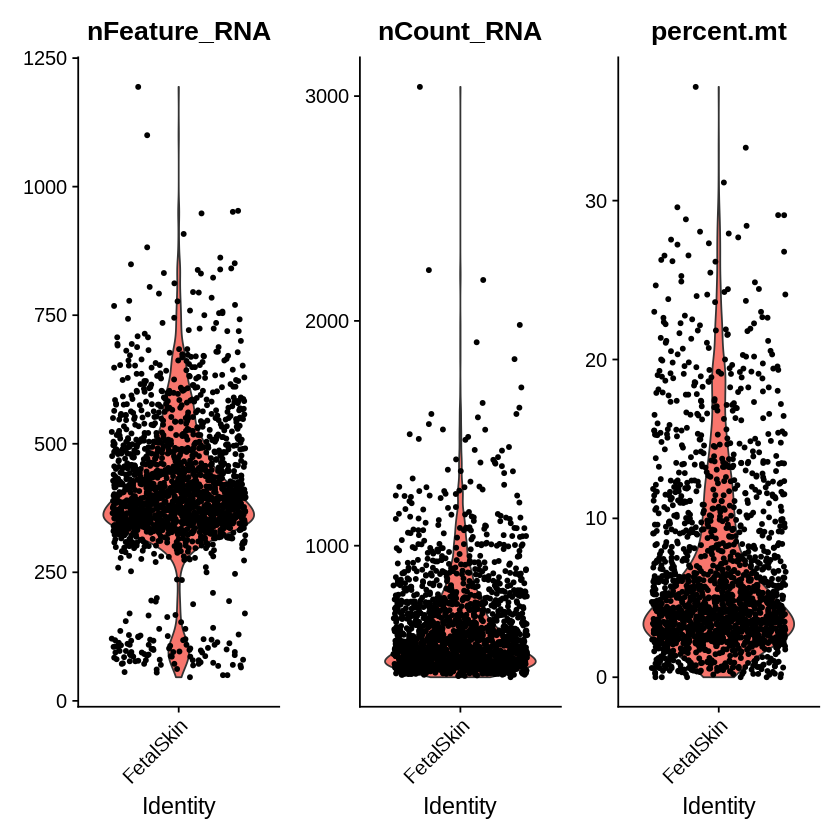

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 10
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  LUM, COL1A2, DCN, COL1A1, SPARC, COL3A1, RPS18, RPL7, RPL34, LGALS1 
	   RPS29, CXCL14, FSTL1, RPS14, HES1, OGN, TMSB10, RPS19, POSTN, MDK 
	   NID2, RPL31, CYR61, SFRP2, PRSS23, PLAC9, RPS3A, ITM2A, GLT8D2, RPL35A 
Negative:  RNASE1, LYVE1, CCL3, CCL3L3, CCL4L2, CD36, CCL4, CXCL8, C1QA, F13A1 
	   SPP1, TNF, MRC1, C1QB, C1QC, IL1B, CYBB, SRGN, LAPTM5, CD14 
	   AGR2, LILRB5, CD163, VSIG4, CREG1, MPEG1, MAF, LGMN, PLEK, ICAM1 
PC_ 2 
Positive:  HMGB2, PTTG1, UBE2C, CDK1, NUSAP1, TOP2A, CCNB1, TUBA1B, CKS2, H2AFZ 
	   CCNB2, UBE2T, CDC20, MAD2L1, CDKN3, KIAA0101, HMGB1, NUF2, BUB1B, KPNA2 
	   CKS1B, CDCA3, PRC1, ARL6IP1, AURKB, PBK, DLGAP5, SMC4, NDC80, CENPW 
Negative:  SPARC, COL1A2, POSTN, DCN, COL1A1, OGN, GLT8D2, GADD45B, KERA, MGP 
	   FSTL1, LOX, NID2, MFAP5, HES1, LUM, COL3A1, PLAC9, CTGF, MDK 
	   ZFP36, ASPN, NOV, PCOLCE, SFRP2, DLK1, FBLN5, FTL, ELN, PRSS23 
PC_ 3 
Positive:  LYVE1, SPP1, LGMN, LILRB5, CREG1, VSIG4, C1QB, C1QA, F13A1, RNASE1 
	   CD36, MRC1

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


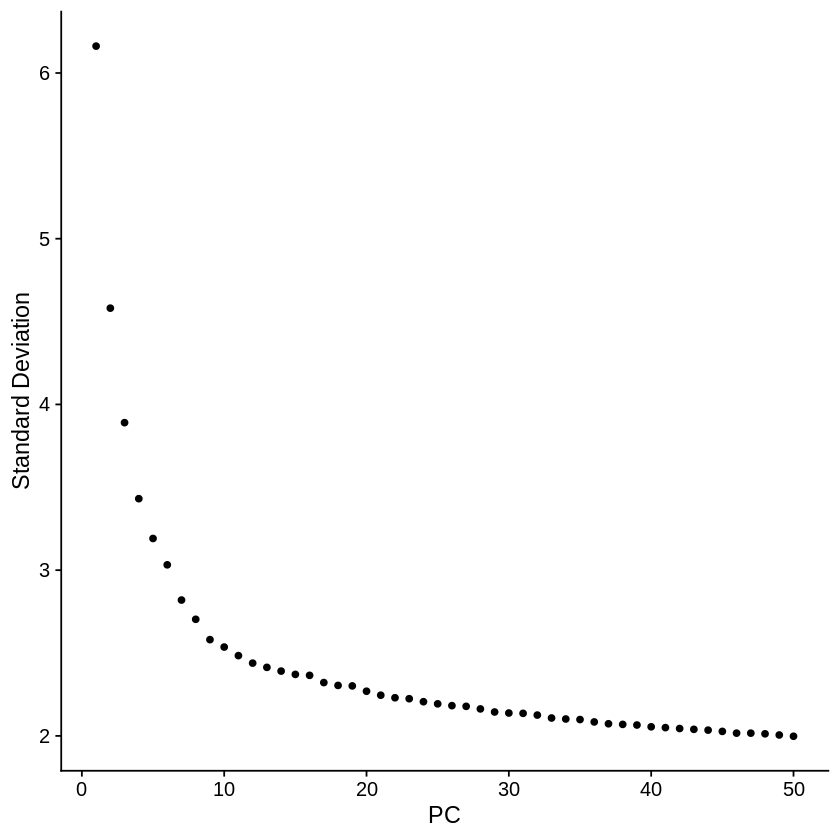

In [9]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [10]:
dev.off()
pcDim = 10 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
04:31:22 UMAP embedding parameters a = 0.9922 b = 1.112

04:31:22 Read 1236 rows and found 10 numeric columns

04:31:22 Using Annoy for neighbor search, n_neighbors = 30

04:31:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

04:31:22 Writing NN index file to temp file /tmp/RtmpdQAMYh/file53246d293dee

04:31:22 Searching Annoy index using 1 thread, search_k = 3000

04:31:22 Annoy recall = 100%

04:31:23 Commencing smooth kNN distance calibration using 1 thread

04:31:23 Initializing fr

In [11]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1236
Number of edges: 45953

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8078
Number of communities: 8
Elapsed time: 0 seconds


04:31:27 UMAP embedding parameters a = 0.9922 b = 1.112

04:31:27 Read 1236 rows and found 10 numeric columns

04:31:27 Using Annoy for neighbor search, n_neighbors = 30

04:31:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

04:31:27 Writing NN index file to temp file /tmp/RtmpdQAMYh/file532451d3b1b9

04:31:27 Searching Annoy index using 1 thread, search_k = 3000

04:31:27 Annoy recall = 100%

04:31:27 Commencing smooth kNN distance calibration using 1 thread

04:31:28 Initializing from normalized Laplacian + noise

04:31:28 Commencing optimization for 500 epochs, with 51380 positive edges

04:31:31 Optimization finished



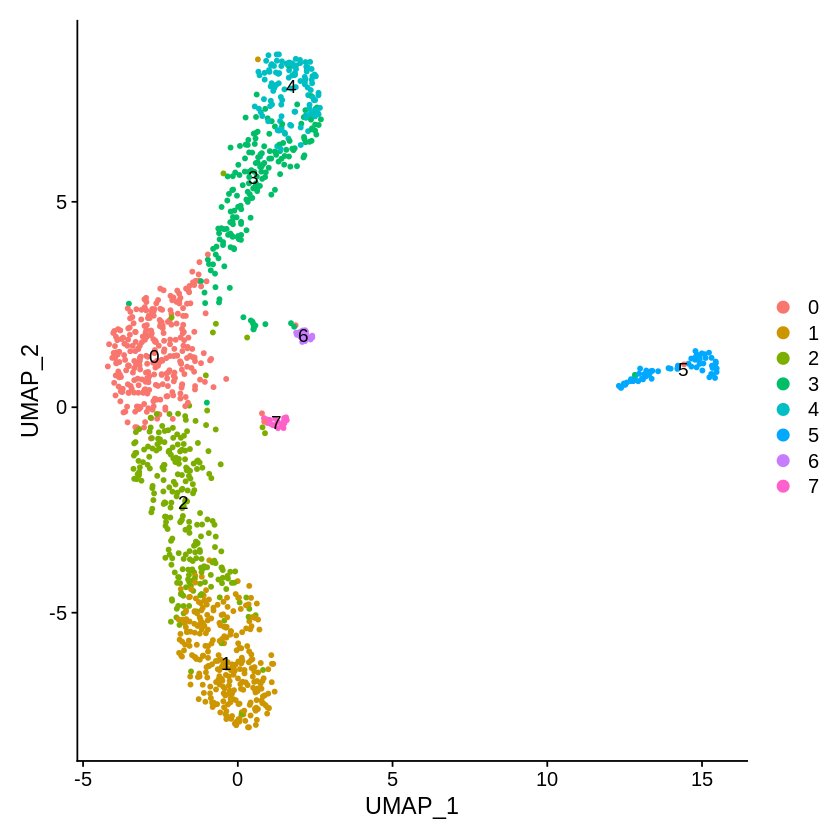

In [12]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [13]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

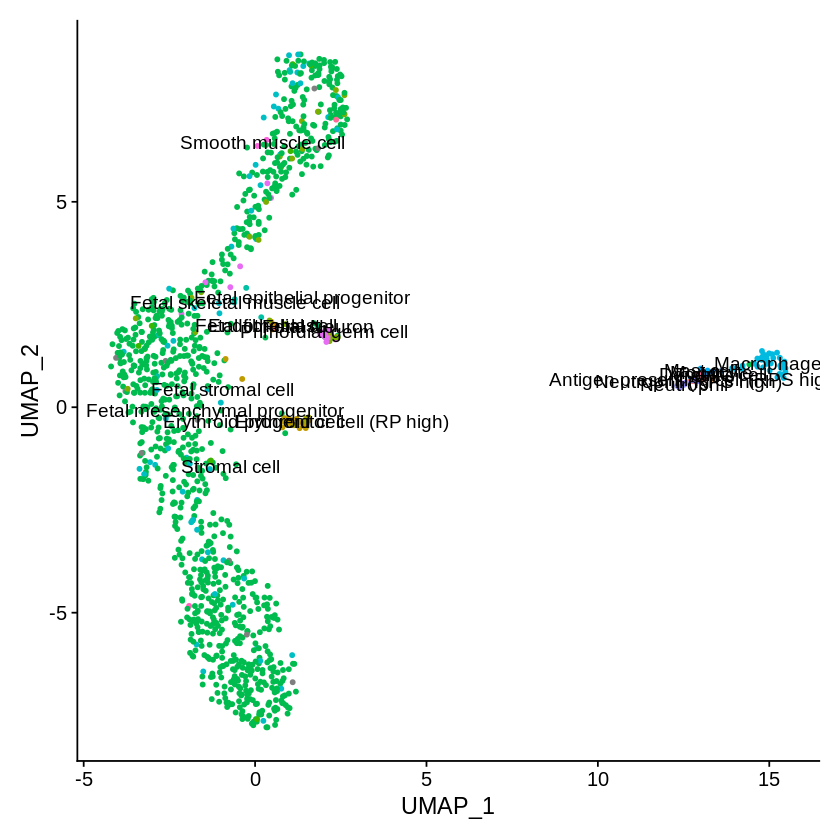

In [16]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [15]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [16]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7



In [17]:
# 还没做annotation
new.cluster.ids <- c('Unknown', 'Skin-Connective tissue-Fibroblast-LUM', 'Skin-Connective tissue-Fibroblast-LUM',
                    'Skin-Proliferating cell-UBE2C', 'Skin-Proliferating cell-UBE2C', 'Skin-Connective tissue-Macrophage-SPP1',
                    'Skin-Epithelial tissue-Melanocyte-MLANA', 'Skin-Connective tissue-Erythroid cell-HBB')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

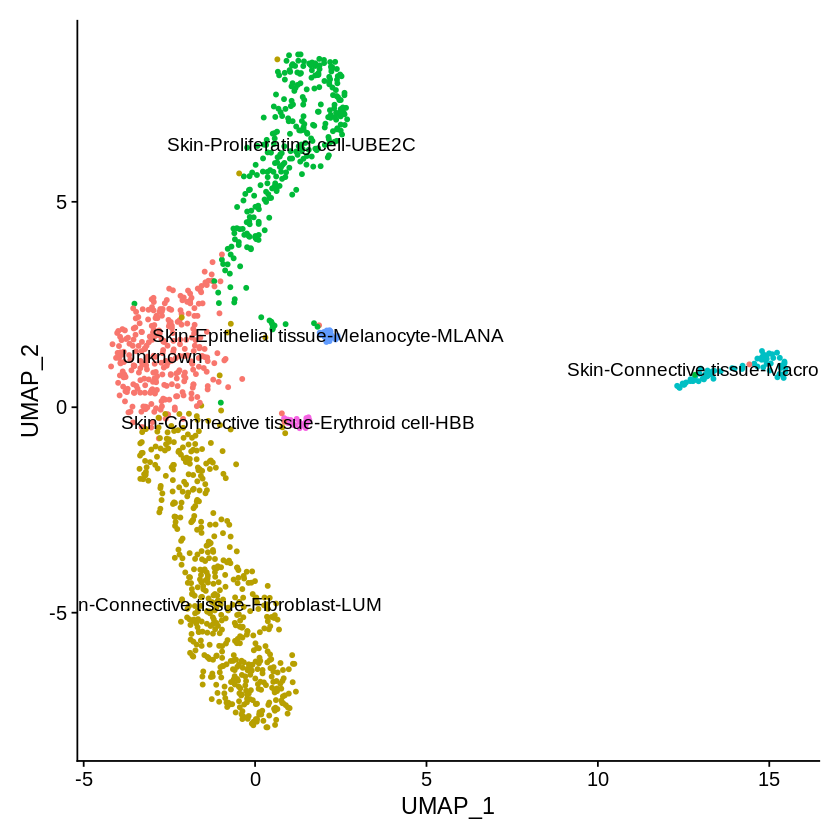

In [18]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [19]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [20]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))